### RNN Model for Stock Analysis

1. import data from csv datsets
    - prices
    - sector and industry 
    - revenue
    - profit
2. compile into timestep sequence
3. create lagged y-value set
4. create model
    - lstm cell
    - dense layer
    - consider another lstm and dense layer
    - output
5. run model based on following inputs for each time step
    - market cap
    - industry (one-hot vector)
    - sector (one-hot vector)
    - revenue
    - profit
6. predict
    - run model up until the known value is done
    - iterate through following values feeding previous output and hidden state

#### Initialize definitions

In [55]:
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf

# using tensorflow.keras may be necessary, keras by itself may not work
from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply, TimeDistributed, Reshape, Dropout
from tensorflow.keras.layers import RepeatVector, Dense, Activation, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, MeanAbsolutePercentageError
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.utils import Sequence
import tensorflow.keras.backend as K

In [56]:
# define constants and filepaths

shareprices_path = 'raw/us-shareprices-daily.csv'
income_path = 'raw/us-income-ttm.csv'
# shareprices_path = 'us-shareprices-latest.csv' # latest data only, helps shorten load time while developing

MAX_DAYS = 9000 # number of total days possible for a stock
T_x = 360 # number of timesteps inputs
T_y = 1 # number of timestep outputs, T_x = T_y or 1, depending on the architecture
# n_a1 = 256 # number of hidden activation units in first LSTM layer
# n_a2 = 256 # number of hidden activation units in second LSTM layer
n_inputs = 5 # number of input variables per timestep
n_values = n_inputs # number of output predicted variables, may be same as n_inputs
n_trailing = T_x # number of trailing days used for prediction
n_forward = 360 # number of timesteps in advance for forward prediction
m = 150000 # number of training examples

sc = MinMaxScaler(feature_range=(0,1))

#### Data Preparation

1. Import all datasets using pandas
2. Add market cap, revenue, profit, and yoy growth by quarter to dataset
    - Make data repeat until following quarter
3. Create a second dataset with sector of the company
4. Slice dataset into arrays of length T_x+1 and pair with sector

In [57]:
def load_dataset(path, cols=None, delimiter=';'):
    
    """
    Loads a dataset from csv file into pandas dataframe.
    
    Parameters:
    path -- filepath to csv
    cols -- column labels to pass into reader, first label should be the date column label
    delimiter -- delimiter of values, default semicolon based on project data
    
    Returns:
    df -- dataframe with values from csv
    """
    
    df = pd.read_csv(path, delimiter=delimiter, usecols=cols)
    df.index = pd.to_datetime(df.pop(cols[0])) # alternatively, df.index = pd.to_datetime(df[cols[0]]); df = df.drop(columns=[cols[0]])
    df.index.name = 'Date' # renames column if date column originally has different name
    
    return df

In [58]:
def clean_data(df, na=False, zeros=None, min_freq=1):
    
    """
    Removes rows with incomplete data, either NaN or zero values, based on specified columns.
    
    Parameters:
    df -- input dataframe
    na -- labels of columns to consider when removing rows with NaN values, default of False removes no rows (False instead of None because None removes all rows)
    zeros -- label of columns considered when removing rows with zero values, default of None removes no rows
    min_freq -- minimum number of rows of a ticker to remain in dataset, default of 1 removes no rows
    
    Returns:
    df -- dataframe with data cleaned
    """
    
    if na == 'all': na = df.columns[df.dtypes!='object'] # sets to columns with non-string dtypes
    if zeros == 'all': zeros = df.columns[df.dtypes!='object']
    
    if not na is False: df = df.dropna(subset=na) # removes all rows with NaN in specified columns, df.dropna(subset=[na], inplace=True) also works if SettingWithCopyWarning appears
    if not zeros is None: df = df[(df[zeros]!=0).all(axis=1)] # removes all rows with zero values in specified columns, see https://stackoverflow.com/a/22650162/6501621 and https://stackoverflow.com/questions/18172851/deleting-dataframe-row-in-pandas-based-on-column-value
    df = df[df.groupby('Ticker')['Ticker'].transform(len) >= min_freq] # removes all rows of a stock if stock has less than min_freq entries, see https://stackoverflow.com/a/48514338/6501621
    
    return df

In [59]:
def add_derived_value(df, method, base_cols, deriv_cols, drop=False, group=None, periods=4):
    
    """
    Computes derived value based on method and parameters. Available derived values: percent change, multiplication.
    
    Parameters:
    df -- input dataframe (required)
    method -- computation to calculate derived values (required)
    base_cols -- list of column labels of base values used to compute derived values (required)
    deriv_cols -- list of column label(s) of derived values to add to dataframe (required)
    drop -- column label(s) to drop after computation (optional)
    group -- column label of grouping if necessary for calculation (optional)
    period -- number of periods between percent change calculation (optional)
    
    Returns:
    df -- dataframe with additional column(s) of derived calculations
    """
    
    # computes percentage change of base columns and adds to dataframe in new columns
    
    if method == 'pctchg':
        growth = lambda x: x.pct_change(periods=periods).backfill() # defines function to compute percent change and backfills missing data
        for base_col, deriv_col in zip(base_cols, deriv_cols): # loops through if applicable to multiple columns
            growth_col = df.groupby(group)[base_col].apply(growth) # applies function by group
            df[deriv_col] = growth_col # assigns derived values to specified column name
        
    # multiplies base columns together to create a new column
    
    elif method == 'multiply':
        multiply = df[base_cols[0]] # initializes variable
        for col in base_cols[1:]: multiply *= df[col] # loops through all other columns to multiply together into variable
        df[deriv_cols] = multiply # assigns derived values to specified column name, only one column can be specified in deriv_cols
        
    if drop: df = df.drop(columns=base_cols) # delete base columns after calculating derived values

    return df

In [60]:
def access_ticker(df, ticker):
    
    """
    Returns the rows of a given ticker.
    
    Parameters:
    df -- input dataframe
    ticker -- stock ticker to retrieve values of
    
    Returns:
    df -- dataframe of rows of selected ticker
    """
    
    if len(df.index.names) <= 1: # access from single index
        return df[df['Ticker']==ticker]
    else: # access from MultiIndex
        return df.loc[ticker]

In [61]:
def rescale_data_by_group(df, group, freq='1D'):
    
    """
    Rescales data from original frequency to specified frequency and forward fills empty rows if upscaling.
    
    Parameters:
    df -- input dataframe to rescale
    group -- column of grouping
    frequency -- frequency of data for each group
    """
    
    rescale = lambda x: x.asfreq(freq).pad() # defines function to rescale data to specified frequency
    df = df.groupby(group).apply(rescale) # applies function by group
    df.pop(group) # df.drop provides same functionality for this use case
    df = df.reset_index(level=0)
    
    return df

In [62]:
def generate_sequences(data, n_trailing=n_trailing, n_forward=n_forward):
    
    """
    Generates all sequences of input array given number of timesteps and length of forward projection.
    
    Parameters:
    data -- input array
    n_trailing -- number of timesteps used in sequence
    n_forward -- projection number of days in advance
    
    Return:
    sequences -- list of sequences generated from array
    """
    
    sequences = []
    
    for i in range(len(data)-n_trailing-n_forward+1):
        sequences.append(np.append(data[i:i+n_trailing], [data[i+n_trailing+n_forward-1]], axis=0)) # appends the n_trailing timesteps and timestep n_forward from most recent timestep
    
    return sequences

In [63]:
def notify(title, text=""):
    
    """
    Displays a desktop notification with specified text.
    
    Parameters:
    title -- title of notification to be displayed
    text -- further details of notification
    
    Returns:
    None
    """
    
    os.system("""
              osascript -e 'display notification "{}" with title "{}"'
              """.format(text, title))

#### Loss Functions

In [64]:
def custom_loss_function(loss, weights):
    
    """
    Computes a loss function with weighting on specific outputs.
    Based on https://keras.io/api/losses/
    https://towardsdatascience.com/how-to-create-a-custom-loss-function-keras-3a89156ec69b
    https://medium.com/@Bloomore/how-to-write-a-custom-loss-function-with-additional-arguments-in-keras-5f193929f7a0
    
    Parameters:
    loss -- loss options (mean squared error, mean absolute percentage error)
    weights -- list of loss weighting of output ['Market Cap', 'Revenue', 'Gross Profit', 'Net Income', 'YoY Revenue']
    
    Returns:
    custom_loss -- defines a custom error with loss weighting
    """
    
    loss_weights = K.constant(np.array([weights]))
    num_weights = np.sum(np.ones(len(weights))) # workaround because it seems multiplying by len(weights) directly doesn't work
    
    if loss == 'mse':
        def custom_loss(y_true, y_pred):
            loss = K.square(y_true - y_pred) # square before weighting losses, otherwise it gets messy
            weighted_loss = Multiply()([loss, loss_weights]) / np.sum(loss_weights) * num_weights # multiply by weights / sum of weights * num weights intuitively makes sense; the sum of (weights / sum of weights) = 1, so to recalibrate based on  original neutral weighting, multiply by length of weights (recalibration is unnecessary but nice)
            return K.mean(weighted_loss)
        
    elif loss == 'mape':
        def custom_loss(y_true, y_pred):
            diff = y_true - y_pred
            loss = 100 * K.abs(diff) / y_true
            weighted_loss = Multiply()([loss, loss_weights]) / np.sum(loss_weights) * num_weights
            return K.mean(weighted_loss)
    
    return custom_loss

In [65]:
y_true = K.constant([1, 4, 1, 5, 1])
y_pred = K.constant([3, 1, 4, 2, 2])
weights = [1,1,1,1,1]
num_weights = np.sum(np.ones(len(weights)))
loss_weights = K.constant(np.array([50000, 1, 1, 1, 1]))
diff = y_true - y_pred
loss = 100 * K.abs(diff) / y_true
weighted_loss = Multiply()([loss, loss_weights]) / np.sum(loss_weights) * num_weights
print(K.mean(weighted_loss))

tf.Tensor(199.9947, shape=(), dtype=float32)


In [66]:
test_true = K.constant([1, 4, 1, 5, 1])
test_pred = K.constant([3, 2, 2, 2, 2])
test_loss_weights = K.constant([1, 1, 1, 1, 1])
test_diff = test_true - test_pred
test_loss = 100 * K.abs(test_diff) / test_true
test_weighted_loss = Multiply()([test_loss, test_loss_weights]) / np.sum(test_loss_weights) * len(test_loss_weights)
# test_true = Multiply()([test_true, test_loss_weights]) / np.sum(test_loss_weights) * len(test_loss_weights)
# test_pred = Multiply()([test_pred, test_loss_weights]) / np.sum(test_loss_weights) * len(test_loss_weights)
# print(test_true.numpy())
# print(test_pred.numpy())
print(K.mean(test_weighted_loss).numpy())
# print(MeanSquaredError()(test_true, test_pred).numpy())
# print(K.mean(K.abs(test_true-test_pred)).numpy())

102.0


#### Data Processing

In [67]:
# initialize income dataset

cols = ['Publish Date', 'Ticker', 'Revenue', 'Gross Profit', 'Net Income']
df_income = load_dataset(path=income_path, cols=cols)
df_income = clean_data(df_income, na='all', zeros='all', min_freq=5) # df_income.dtypes!='object'] is essentially everything except strings, don't forget it is '!=', not '=='
df_income = add_derived_value(df=df_income, method='pctchg', group='Ticker', base_cols=['Revenue'], deriv_cols=['YoY Revenue'], periods=4) # add YoY revenue column by calculating percent change
df_income = rescale_data_by_group(df_income, group='Ticker', freq='1D') # somehow turns 'Net Income' from int64 to float64?

In [68]:
# initialize prices dataset

cols = ['Date', 'Ticker', 'Close', 'Shares Outstanding']
df_prices = load_dataset(path=shareprices_path, cols=cols)
df_prices = clean_data(df_prices, na='all', zeros='all')

In [69]:
# compute marketcap and remove other variables

df_prices = add_derived_value(df=df_prices, method='multiply', base_cols=['Close', 'Shares Outstanding'], deriv_cols=['Market Cap'], group='Ticker', drop=True)
df_prices = df_prices[df_prices['Market Cap'] > 1e9] # only companies of value $1B or more

In [70]:
# merge income and prices

df_main = df_prices.merge(df_income, on=['Ticker', 'Date'], how='inner') # inner means stock must be included in both pre-merge; if MultiIndex, the on=[] parameter determines order of pivot table
# assert not np.any(np.isnan(df_main))
assert not df_main.isna().any(None)

In [71]:
# scale data

cols = df_main.columns[df_main.dtypes=='float64'] # ['Market Cap', 'Revenue', 'Gross Profit', 'Net Income']

sc = MinMaxScaler(feature_range=(1e-15,1)) # duplicate initialization but useful to define here too, see https://stackoverflow.com/questions/49330195/how-to-use-inverse-transform-in-minmaxscaler-for-a-column-in-a-matrix for more on MinMaxScaler
df_main[cols] = sc.fit_transform(df_main[cols])
df_main[cols] = np.log(df_main[cols])
sc2 = MinMaxScaler(feature_range=(0,1)) # not sure if necessary
df_main[cols] = sc2.fit_transform(df_main[cols])

In [72]:
# df_main.pop('Revenue')
# df_main.pop('Gross Profit')
# df_main.pop('Net Income')
# df_main.pop('YoY Revenue')

In [73]:
df_main

,Ticker,Market Cap,Revenue,Gross Profit,Net Income,YoY Revenue
Date,,,,,,
2014-03-27,GOOG,0.880509,0.938509,0.958657,0.973359,0.920496
2014-03-28,GOOG,0.880589,0.938509,0.958657,0.973359,0.920496
2014-03-31,GOOG,0.900680,0.938509,0.958657,0.973359,0.920496
2014-04-01,GOOG,0.901206,0.938509,0.958657,0.973359,0.920496
2014-04-02,GOOG,0.901198,0.938509,0.958657,0.973359,0.920496
...,...,...,...,...,...,...
2020-02-14,MAXR,0.674088,0.883497,0.908467,0.963075,0.920365
2020-02-18,MAXR,0.652219,0.883497,0.908467,0.963075,0.920365
2020-02-19,MAXR,0.638954,0.883497,0.908467,0.963075,0.920365


In [74]:
# convert to list of numpy arrays

df_main = pd.pivot_table(df_main, index=['Ticker', 'Date']).reindex(columns=df_main.columns[1:]) # see https://stackoverflow.com/questions/36346071/pandas-pivot-table-changing-order-of-non-index-columns
export = lambda x: x.to_numpy()
dataset = df_main.groupby('Ticker').apply(export)

In [75]:
# convert to training data format

full_dataset = []
for i, stock_data in enumerate([dataset['UAL']]):
    full_dataset += generate_sequences(stock_data) # see https://www.geeksforgeeks.org/python-ways-to-concatenate-two-lists/

In [76]:
# convert to np array

full_data = np.asarray(full_dataset)
# np.save('saved/dataset', full_data)

In [77]:
# load from npy file

# full_data = np.load('saved/dataset.npy')

In [78]:
full_data.shape

(1698, 361, 5)

In [79]:
indices = np.arange(len(full_data))
random.shuffle(indices)
m = 2416
X = full_data[indices[:m],:-1,:]
Y = full_data[indices[:m],-1:,:]
Y = Y.reshape(Y.shape[0], Y.shape[2])

#### Model Attempt 5

In [80]:
def model5_v1():
    
    """
    This model is based on model v4.1 but extends the input to 5 inputs and 5 outputs. Designed with a larger dataset
    in mind and additional computation power.
    """
    
    X_input = Input(shape=(T_x, n_inputs))
    X = LSTM(units=128, return_sequences=True)(X_input)
    X = TimeDistributed(Dense(units=256))(X)
    X = LSTM(units=256, return_sequences=True)(X)
    X = TimeDistributed(Dense(units=256))(X)
    X = LSTM(units=128)(X)
    X = Dropout(0.3)(X)
    X = Dense(units=128)(X)
    output = Dense(units=n_values)(X)
    
    model = Model(inputs=X_input, outputs=output)
    
    return model

In [81]:
def model5():
    
    """
    This model is based on model v4.1 but extends the input to 5 inputs and 5 outputs. Designed with a larger dataset
    in mind and additional computation power.
    """
    
    X_input = Input(shape=(T_x, n_inputs))
    X = LSTM(units=128, return_sequences=True)(X_input)
    X = TimeDistributed(Dense(units=256))(X)
    X = LSTM(units=128)(X)
    X = Dropout(0.2)(X)
    X = Dense(units=128)(X)
    output = Dense(units=n_values)(X)
    
    model = Model(inputs=X_input, outputs=output)
    
    return model

In [82]:
# consider using a data generator, see https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(32,32,32), n_channels=1,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = np.load('data/' + ID + '.npy')

            # Store class
            y[i] = self.labels[ID]

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [83]:
model = model5_v1()
model.compile(optimizer='adam', loss=custom_loss_function(loss='mse', weights=[1,1,1,1,1]), metrics=['mape']) # consider loss='msle' (mean squared logarithmic error, https://keras.io/api/losses/regression_losses/#meansquaredlogarithmicerror-class), or log during preprocessing (see https://stats.stackexchange.com/questions/213897/best-way-to-optimize-mape)

In [84]:
model.fit(X, Y, batch_size=32, epochs=15)

Train on 1698 samples
Epoch 1/15
1698/1698 [==============================] - 215s 126ms/sample - loss: 0.0467 - mape: 15.6996
Epoch 2/15
1698/1698 [==============================] - 216s 127ms/sample - loss: 0.0081 - mape: 7.8245
Epoch 3/15
1698/1698 [==============================] - 195s 115ms/sample - loss: 0.0052 - mape: 6.3400
Epoch 4/15
1698/1698 [==============================] - 196s 116ms/sample - loss: 0.0048 - mape: 6.0519
Epoch 5/15
1698/1698 [==============================] - 197s 116ms/sample - loss: 0.0039 - mape: 5.4717
Epoch 6/15
1698/1698 [==============================] - 220s 130ms/sample - loss: 0.0037 - mape: 5.2781
Epoch 7/15
1698/1698 [==============================] - 229s 135ms/sample - loss: 0.0026 - mape: 4.4615
Epoch 8/15
1698/1698 [==============================] - 227s 134ms/sample - loss: 0.0025 - mape: 4.3987
Epoch 9/15
1698/1698 [==============================] - 230s 135ms/sample - loss: 0.0024 - mape: 4.2331
Epoch 10/15
1698/1698 [==================

In [85]:
notify("Model", "Model training complete")

In [86]:
# model.save('saved/weights_m2_UAL.h5', overwrite=False)

#### Output and Prediction

In [87]:
# X2 = full_data[indices[m:m+0],:-1,:]
# Y2 = full_data[indices[m:m+0],-1:,:]
# Y2 = Y2.reshape(Y2.shape[0], Y2.shape[2])
model.evaluate(X, Y, verbose=0)

[0.0004019890996891878, 2.1637535]

In [88]:
# X3 = full_data[indices[1000],:-1,:]
# Y3 = full_data[indices[1000],-1:,:]
# print(sc.inverse_transform(model.predict(X3.reshape(1, *X3.shape))))
# print(sc.inverse_transform(X3))
# print(sc.inverse_transform(Y3))

In [89]:
n_backtest = 1500
n_predictions = 5

sample_stock = 'UAL'
sample_data = dataset[sample_stock].copy()
rolling_input = sample_data[(-n_forward-n_trailing+1)-n_backtest:-n_backtest] # selects all timesteps necessary for n_backtest predictions to run, and then enough to continue in a cycle (i.e., n_trailing+n_forward-1)
sample_output = []
for i in range(n_predictions):
    sample_input = np.array(rolling_input[:n_trailing]) # selects the first n_trailing timesteps to make the next prediction
    sample_input = sample_input.reshape(1, *sample_input.shape) # reshape into model input format
    sample_output.append(model.predict(sample_input).ravel())
    rolling_input[:-1] = rolling_input[1:] # shift one to the left
    rolling_input[-1:] = sample_output[i]
#     print(sample_input[0,0], ", ", sample_output[i])
sample_output = np.array(sample_output)

In [90]:
sample_output[0]

array([0.8288307, 0.9487168, 0.9586029, 0.9849829, 0.9391073],
      dtype=float32)

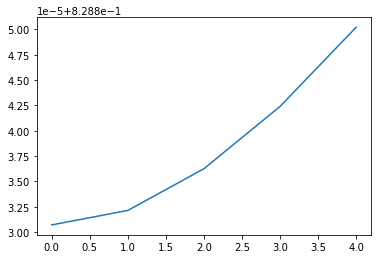

In [91]:
plt.plot(sample_output[:,0])

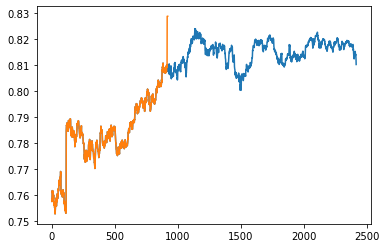

In [92]:
val = 0
output = np.append((dataset[sample_stock][:-n_backtest-1])[:,val], sample_output[:,val])
sample_Y = (dataset[sample_stock])[:,val]

plt.plot(sample_Y)
plt.plot(output)

In [93]:
sample_data = np.array(generate_sequences(dataset[sample_stock]))[:,:-1]
sample_output = model.predict(sample_data)

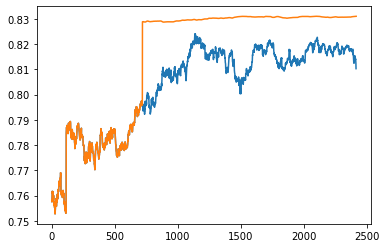

In [94]:
val = 0
output = np.append((dataset[sample_stock][:n_trailing+n_forward])[:,val], sample_output[:,val])
sample_Y = (dataset[sample_stock])[:,val]

plt.plot(sample_Y)
plt.plot(output)

In [96]:
notify("Model", "Model prediction complete")

In [ ]:
# plt.plot(access_ticker(df_prices, 'AAPL')['Market Cap'])
plt.plot(dataset[sample_stock][:,0])

#### Model Attempt 4

Data preparation methods below are for model versions up to 4.1. Defined methods are for model versions up to 3.0.

In [ ]:
# load prices of shares from the daily share price values
# for with open as f documentation, see https://likegeeks.com/numpy-loadtxt-tutorial

with open(shareprices_path) as f:
    cols = f.readline().split(';')
    sample = f.readline().split(';')

# identify columns of interest and indices

col_names = ['Ticker', 'SimFinId', 'Date', '"Adj. Close"', '"Shares Outstanding"\n']
col_nums = []
for name in col_names:
    col_nums.append(cols.index(name))
col_names = ['Ticker', 'SimFinId', 'Date', 'Price', 'Shares']
    
# for cols.index documentation, see https://stackoverflow.com/questions/176918/finding-the-index-of-an-item-in-a-list
# using np.genfromtxt instead of np.loadtxt because more flexibility with datatype (and no issue with floats)

prices = np.genfromtxt(open(shareprices_path), 
                    delimiter=';', 
                    skip_header=1, 
                    usecols=(col_nums), 
                    dtype={'names': col_names,
                     'formats': ('U6', 'i8', 'U10', 'f8', 'i8')})

In [ ]:
def get_stock_price(prices, ticker):
    
    """
    Retrieves the stock price of a given ticker across time.
    
    Parameters:
    prices -- numpy array of stock prices with ticker, price, and shares outstanding
    ticker -- string, ticker for stock
    
    Return:
    price -- numpy array of price
    """
    
    price = marketcap = prices[prices['Ticker']==ticker]['Price']
    
    return price

In [5]:
def get_market_cap(prices, ticker, threshold=0.5):
    
    """
    Retrieves the market cap of a given ticker across time.
    
    Parameters:
    prices -- numpy array of stock prices with ticker, price, and shares outstanding
    ticker -- string, ticker for stock
    threshold -- minimum market cap acceptable in output, in order to add robustness (default 0.5B)
    
    Return:
    marketcap -- numpy array of market cap, in billions
    """
    
    marketcap = prices[prices['Ticker']==ticker]['Price'] * prices[prices['Ticker']==ticker]['Shares'] / 1000000000
    marketcap = marketcap[marketcap>threshold]
    
    return marketcap

In [6]:
def prep_dataset(size):
    
    """
    Creates the dataset for training
    """
    
    # finds all stock tickers and randomly selects
    
    tickers = list(set(prices['Ticker']))
    ticker_set = random.sample(tickers, k=size)
    
    divisor = int(MAX_DAYS/T_x) # reduces dataset by a factor of divisor to fit within T_x timesteps
    
    # initialize output variables
    
    full_dataset = np.zeros((len(ticker_set), T_x+n_lag)) # very large number temporarily
    X = np.zeros((len(ticker_set), T_x))
    Y = np.zeros((len(ticker_set), T_x))
    
    # loop through tickers to compile dataset
    
    for i, ticker in enumerate(ticker_set):
        
        # retrieve market cap and number of values
        
        marketcap = get_market_cap(prices, ticker, threshold=2.0)
        n_prices = len(marketcap)
        
        marketcap = marketcap[::divisor] # reduces length of array by a factor of dataset to keep within T_x timesteps
        n_prices = len(marketcap)
        
        # apply values to dataset and variables
        
        full_dataset[i, full_dataset.shape[1]-n_prices:] = marketcap
    
#     full_dataset = sc.fit_transform(full_dataset)
    
    for i, ticker in enumerate(ticker_set):
        X[i, :] = full_dataset[i, :full_dataset.shape[1]-n_lag]
        Y[i] = full_dataset[i, n_lag:]
    
    X = X.reshape((X.shape[0], X.shape[1], 1))
    Y = Y.reshape((Y.shape[0], Y.shape[1], 1))
    
    return full_dataset, X, Y, ticker_set

In [34]:
aaplmktcap = get_market_cap(prices, 'AAPL')

In [35]:
num_days_aapl = len(aaplmktcap)
dataset = np.zeros((num_days_aapl-n_trailing-n_lag+1, n_trailing+1)) # make sure the shape of np array is correct
for i in range(num_days_aapl-n_trailing-n_lag+1):
    dataset[i] = np.append(aaplmktcap[i:i+n_trailing], aaplmktcap[i+n_trailing+n_lag-1]) # make sure to include [start:end] correct syntax
X = dataset[:,:-1]
Y = dataset[:,-1:]
print(Y)

[[ 105.84970813]
 [ 105.09722205]
 [ 106.85302289]
 ...
 [1070.9424848 ]
 [1062.8916016 ]
 [ 995.3341904 ]]


In [36]:
def model4():
    
    """
    Uses an LSTM model with dense layers to predict n_lag days in advance, distinct from other models in only yielding one prediction.
    Version: 4.1
    """
    
    X_input = Input(shape=(T_x, n_inputs))
    X = LSTM(units=128, return_sequences=True)(X_input)
    X = Dense(units=256)(X)
    X = LSTM(units=128)(X)
    X = Dropout(0.2)(X)
    X = Dense(units=64)(X)
    output = Dense(units=n_values, activation='relu')(X)
    
    model = Model(inputs=X_input, outputs=output)
    
    return model

In [ ]:
def model4_v0():
    X_input = Input(shape=(T_x, n_inputs))
    X = LSTM(units=128)(X_input)
    output = Dense(units=n_values, activation='relu')(X)
    model = Model(inputs=X_input, outputs=output)
    return model

In [37]:
model = model4()
model.summary()
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 180, 1)]          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 180, 128)          66560     
_________________________________________________________________
dense_8 (Dense)              (None, 180, 256)          33024     
_________________________________________________________________
lstm_7 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65  

In [38]:
X = X.reshape(X.shape[0], X.shape[1], 1)
model.fit(X, Y, batch_size=32, epochs=15) # small batch size (batch_size < 64) helps

Train on 2695 samples
Epoch 1/15
2695/2695 [==============================] - 83s 31ms/sample - loss: 305480.1206 - mean_squared_error: 305480.1562
Epoch 2/15
2695/2695 [==============================] - 78s 29ms/sample - loss: 131569.7970 - mean_squared_error: 131569.8281
Epoch 3/15
2695/2695 [==============================] - 77s 28ms/sample - loss: 75596.6667 - mean_squared_error: 75596.6562
Epoch 4/15
2695/2695 [==============================] - 78s 29ms/sample - loss: 37749.7734 - mean_squared_error: 37749.7812
Epoch 5/15
2695/2695 [==============================] - 77s 29ms/sample - loss: 12667.9320 - mean_squared_error: 12667.9307
Epoch 6/15
2695/2695 [==============================] - 78s 29ms/sample - loss: 7951.2288 - mean_squared_error: 7951.2290
Epoch 7/15
2695/2695 [==============================] - 78s 29ms/sample - loss: 6831.0970 - mean_squared_error: 6831.0981
Epoch 8/15
2695/2695 [==============================] - 79s 29ms/sample - loss: 5760.5596 - mean_squared_error

In [39]:
aaplmktcap = get_market_cap(prices, 'AAPL')
predictions = np.zeros((1000, 1))
data = np.array(aaplmktcap[-n_lag-n_trailing-1300:-n_lag-1300])
data = data.reshape(1, data.shape[0], 1)
print(data.shape)
for i in range(1000):
    predictions[i] = model.predict(data)
    data[:,:-1,:] = data[:,1:,:]
    data[:,-1:,:] = predictions[i]

(1, 180, 1)


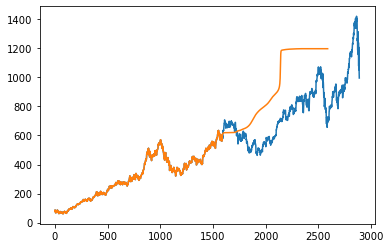

In [40]:
alldata = np.append(aaplmktcap, predictions)
sequence2 = np.append(aaplmktcap[:-1300], predictions)
plt.plot(aaplmktcap)
plt.plot(sequence2)